<img src="https://fitsmallbusiness.com/wp-content/uploads/2017/07/zillow.png" style="float: left; margin: 20px; height: 60px">

# Estimating home prices with linear regression

_Author: Hussain Burhani_

---

This Jupyter notebook contains the steps for building a linear regression model for predicting home prices in Ames, IA. The process entails:
- Gathering, exploring, and cleaning the dataset
- Splitting the dataset, feature engineering and scaling
- Instantiating, fitting, predicting, and evaluting

### 1. Import libraries

In [1]:
# Import libraries and set global variables
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 4000

### 2. Execute functions
Functions are included at the top of the notebook as they need to be initialized before they can be used.
Ignore for now, and we will re-visit them when we call them.

In [2]:
# Function: convert null value in Lot Frontage to mean of column
def impute_null_lot_frontage(df):
    mean_lot_frontage = df['Lot Frontage'].mean()
    df['Lot Frontage'] = df.fillna(mean_lot_frontage)
    return df

In [3]:
# Function: convert df_numeric null values to zeroes
def convert_to_null(df_numeric):
    # Convert numeric null values to zeroes
    df_numeric = df_numeric.fillna(0)
    # Variations:
    #  fillna(method=ffill, axis=1) : propogate pervious value forward (consecutive nulls remain nulls)
    #  fillna(method=bfill, axis=1) : propogate following value backward (consecutive nulls remain nulls)
    #  Fill with mean value of column
    return df_numeric

In [4]:
# Function: Convert nominal columns to dummy variable in new df
def convert_to_dummies(df_numeric, columns):
    for column in columns:
        df_numeric = pd.get_dummies(data=df_numeric, columns=[column], drop_first=True)
    return df_numeric

In [5]:
# Function: Convert ordinal objects to ordinal numbers
def convert_to_ordinal(df, columns):
    for column in columns:
        ord_dict = get_ordinal_dict(column)
        df[column] = df[column].map(ord_dict).astype(int)
    return df

# Function: Get mapping of ordinal data from defined dictionary
def get_ordinal_dict(feature):
    ordinal_feature = {
        'Lot Shape': {
            np.nan: 0,
            'Reg': 1,
            'IR1': 2,
            'IR2': 3,
            'IR3': 4
            }, 
        'Utilities': {
            np.nan: 0,
            'ELO': 1,
            'NoSeWa': 2,
            'NoSewr': 3,
            'AllPub': 4           
            },
        'Land Slope': {
            np.nan: 0,
            'Sev': 1,
            'Mod': 2,
            'Gtl': 3
        },
        'Overall Qual': {
            np.nan: 0,
            1: 1,
            2: 2,
            3: 3,
            4: 4,
            5: 5,
            6: 6,
            7: 7,
            8: 8,
            9: 9,
            10: 10
        },
        'Overall Cond': {
            np.nan: 0,
            1: 1,
            2: 2,
            3: 3,
            4: 4,
            5: 5,
            6: 6,
            7: 7,
            8: 8,
            9: 9,
            10: 10
        },
        'Exter Qual': {
            np.nan: 0,
            'Po': 1,
            'Fa': 2,
            'TA': 3,
            'Gd': 4,
            'Ex': 5
        },
        'Exter Cond': {
            np.nan: 0,
            'Po': 1,
            'Fa': 2,
            'TA': 3,
            'Gd': 4,
            'Ex': 5
        },
        'Bsmt Qual': {
            np.nan: 0,
            'Po': 1,
            'Fa': 2,
            'TA': 3,
            'Gd': 4,
            'Ex': 5
        },
        'Bsmt Cond': {
            np.nan: 0,
            'Po': 1,
            'Fa': 2,
            'TA': 3,
            'Gd': 4,
            'Ex': 5
        },
        'Bsmt Exposure': {
            np.nan: 0,
            'No': 1,
            'Mn': 2,
            'Av': 3,
            'Gd': 4
        },
        'BsmtFin Type 1': {
            np.nan: 0,
            'Unf': 1,
            'LwQ': 2,
            'Rec': 3,
            'BLQ': 4,
            'ALQ': 5,
            'GLQ': 6
        },
        'BsmtFin Type 2': {
            np.nan: 0,
            'Unf': 1,
            'LwQ': 2,
            'Rec': 3,
            'BLQ': 4,
            'ALQ': 5,
            'GLQ': 6
        },
        'Heating QC': {
            np.nan: 0,
            'Po': 1,
            'Fa': 2,
            'TA': 3,
            'Gd': 4,
            'Ex': 5
        },
        'Electrical': {
            np.nan: 0,
            'Mix': 1,
            'FuseP': 2,
            'FuseF': 3,
            'FuseA': 4,
            'SBrkr': 5
        },
        'Kitchen Qual': {
            np.nan: 0,
            'Po': 1,
            'Fa': 2,
            'TA': 3,
            'Gd': 4,
            'Ex': 5
        },
        'Functional': {
            np.nan: 0,
            'Sal': 1,
            'Sev': 2,
            'Maj2': 3,
            'Maj1': 4,
            'Mod': 5,
            'Min2': 6,
            'Min1': 7,
            'Typ': 8
        },
        'Fireplace Qu': {
            np.nan: 0,
            'Po': 1,
            'Fa': 2,
            'TA': 3,
            'Gd': 4,
            'Ex': 5
        },
        'Garage Finish': {
            np.nan: 0,
            'Unf': 1,
            'RFn': 2,
            'Fin': 3,
        },
        'Garage Qual': {
            np.nan: 0,
            'Po': 1,
            'Fa': 2,
            'TA': 3,
            'Gd': 4,
            'Ex': 5
        },
        'Garage Cond': {
            np.nan: 0,
            'Po': 1,
            'Fa': 2,
            'TA': 3,
            'Gd': 4,
            'Ex': 5
        },
        'Paved Drive': {
            np.nan: 0,
            'N': 1,
            'P': 2,
            'Y': 3,
        },
        'Pool QC': {
            np.nan: 0,
            'Fa': 1,
            'TA': 2,
            'Gd': 3,
            'Ex': 4
        },
        'Fence': {
            np.nan: 0,
            'MnWw': 1,
            'GdWo': 2,
            'MnPrv': 3,
            'GdPrv': 4
        }
    }
    return ordinal_feature[feature]

In [6]:
# Function: compare training set feature columns to test set. 
#  If test set is missing any, create the missing one populated with zeros
def correct_feature_columns(features, df_ftest):
    features_ftest = df_ftest.columns.tolist()
    if set(features) != set(features_ftest):
        missing_cols = set(features) - set(features_ftest)
        for col in missing_cols:
            df_ftest[col] = 0
    df_ftest = df_ftest[features]
    return df_ftest

### 3. Exploratory data analysis

In [7]:
# Load dataset
df = pd.read_csv('./datasets/train.csv')

In [8]:
# Review dataframe header
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [9]:
# Review data types
pd.DataFrame(df.dtypes).T

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,int64,int64,int64,object,float64,int64,object,object,object,object,object,object,object,object,object,object,object,object,int64,int64,int64,int64,object,object,object,object,object,float64,object,object,object,object,object,object,object,float64,object,float64,float64,float64,object,object,object,object,int64,int64,int64,int64,float64,float64,int64,int64,int64,int64,object,int64,object,int64,object,object,float64,object,float64,float64,object,object,object,int64,int64,int64,int64,int64,int64,object,object,object,int64,int64,int64,object,int64


### 3. Munging dataset and re-assigning categorical and ordinal columns

In [10]:
# Convert null 'Lot Frontage' to mean value of 'Lot Frontage'
df = impute_null_lot_frontage(df)
# This column should have a non-zero value. The average of the column is a generalization.
#  Alernate: use mean based on criteria. As an example pick the most correlated variable to Lot Frontage.
#             Calculate the mean based on that categorical metric

Ascertain features by reviewing [data dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) and determine whether ordinary numerical, ordinal, or categorical
  - Convert ordinal to numerical categories in ordered form
  - Convert categorical data into dummy variables

In [11]:
# Convert ordinal objects to ordinal numbers. Mimic for testing.
ordinal_list = ['Lot Shape', 'Utilities', 'Land Slope', 'Overall Qual', 'Overall Cond', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence']
df = convert_to_ordinal(df, columns=ordinal_list)

In [12]:
# Convert nominal columns to dummy variable in new df. Mimic for testing
dummy_list = ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air', 'Garage Type', 'Misc Feature', 'Sale Type']
df = convert_to_dummies(df, columns=dummy_list)

Check if any non-numeric columns remaining and determine how to handle.  If information for the model cannot be engineered from non-numerical columns then drop them.

In [13]:
# Check numeric columns for null values. 
df = df[df.select_dtypes(np.number).columns.tolist()]
df.isnull().sum().sort_values(ascending=False).head()

Garage Yr Blt     114
Mas Vnr Area       22
Bsmt Half Bath      2
Bsmt Full Bath      2
Garage Cars         1
dtype: int64

In [14]:
# Convert df_numeric null values to zeroes. Mimic for testing.
df = convert_to_null(df)
# Alternate: Further evaluate methodologies for imputing null values

### 4. Feature engineering and selection

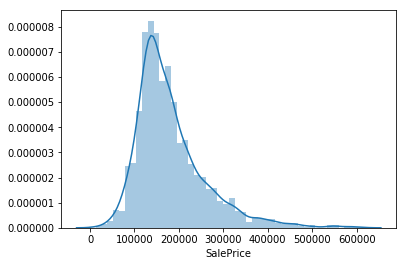

In [15]:
# Assign target variable and view distribution
y = df['SalePrice']
sns.distplot(y);
# Alternate: Use log(y) to normalize values, do the same for the feature variables, and at end 'un-log' them

In [16]:
# Assign tentative feature variables
features = df.columns
X = df[features]

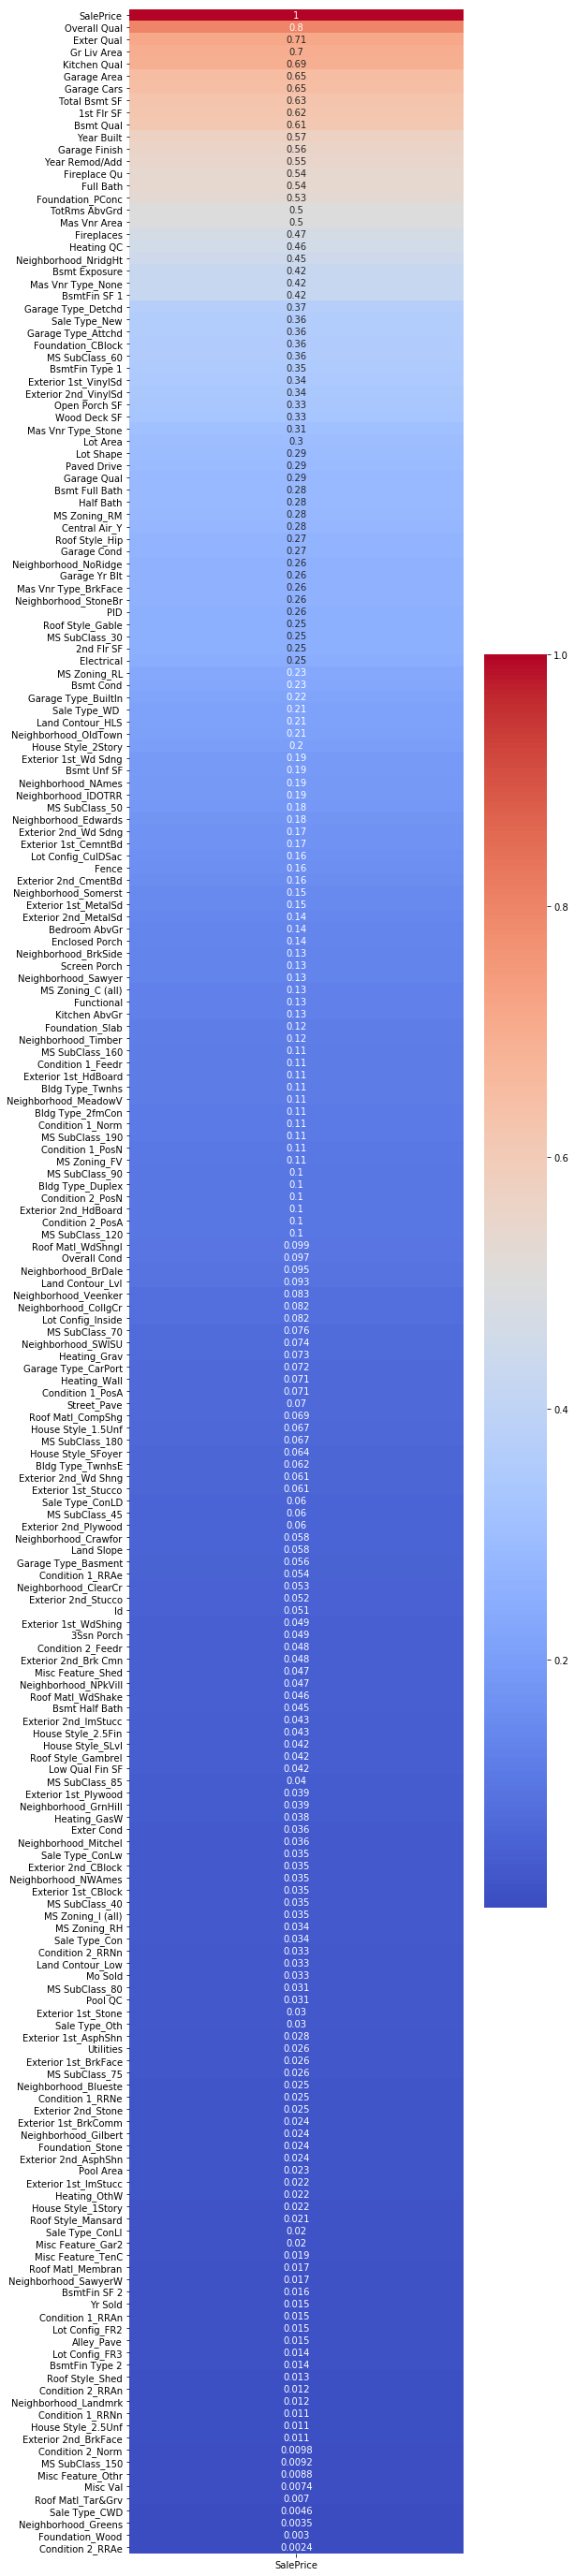

In [17]:
# Discover how feature variables relate to target
df_corr_abs = df.corr()[['SalePrice']].abs().sort_values('SalePrice', ascending=False)
plt.figure(figsize=(8, 50))
sns.heatmap(df_corr_abs, cmap='coolwarm', annot=True)

In [18]:
# Remove target column and extraneous columns from feature list and assign to X
features = df_corr_abs.index.tolist()
features = [col for col in df[features] if col not in ['SalePrice', 'PID', 'Id']]
print("Total number of available features: {}".format(len(features)))
features = features[0:10]
X = df[features]
print("Total number of selected features: {}. Based on highest absolute correlation".format(len(features)))

Total number of available features: 206
Total number of selected features: 10. Based on highest absolute correlation


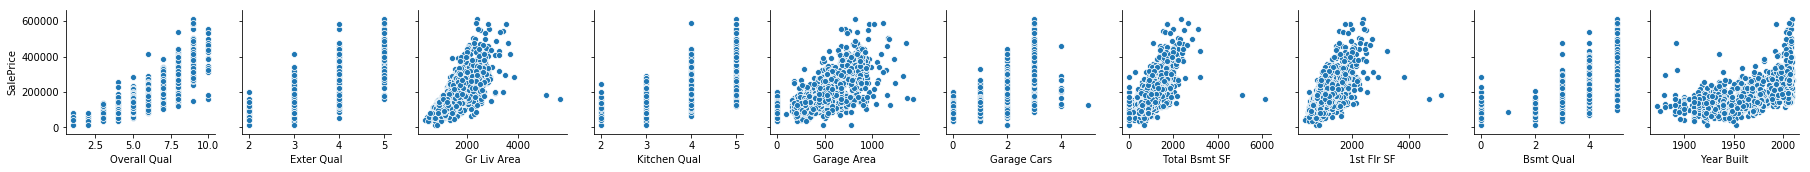

In [19]:
# Observe relationship of target variable to features
sns.pairplot(df, y_vars=['SalePrice'], x_vars=features)

In [20]:
# Split dataset into training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [21]:
# Create interaction terms en masse via PolynomialFeatures
poly = PolynomialFeatures(include_bias=False)
X_train_p = poly.fit_transform(X_train)
X_test_p = poly.transform(X_test)

In [22]:
# Scale features
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train_p)
X_test_ss = ss.transform(X_test_p)

### 5. Instatiate, fit, predict, and evaluate the linear regression model

In [23]:
# Instatiate, fit, and predict using a linear regression model
kf = KFold(n_splits=10, shuffle=True, random_state=42) # Utilize KFold technique
#lm = LinearRegression(n_jobs=3)
#lm = RidgeCV(alphas=np.logspace(0, 5, 200), cv=kf)
lm = LassoCV(alphas=np.logspace(0, 5, 200), cv=kf, n_jobs=3)
_ = lm.fit(X_train_ss, y_train)
y_train_hat = lm.predict(X_train_ss)
cvs_train = cross_val_score(lm, X_train_ss, y_train, cv=kf).mean()
rms_train = np.sqrt(mean_squared_error(y_train, y_train_hat))

In [24]:
# Validate test data using model
y_test_hat = lm.predict(X_test_ss)
kf = KFold(n_splits=10, shuffle=True, random_state=42) 
cvs_test = cross_val_score(lm, X_test_ss, y_test, cv=kf).mean()
rms_test = np.sqrt(mean_squared_error(y_test, y_test_hat))

In [25]:
# Compare deltas between training and testing data
cvs_delta = ((cvs_test - cvs_train) / cvs_train) * 100
rms_delta = ((rms_test - rms_train) / rms_train) * 100

In [26]:
# Print training and testing data evalution metrics and deltas
print('cvs_train: {0:.4f}\nrms_train: {1:.0f}'.format(cvs_train, rms_train))
print('cvs_test: {0:.4f}\nrms_test: {1:.0f}'.format(cvs_test, rms_test))
print('cvs_delta: {0:.2f}%\nrms_delta: {1:.2f}%'.format(cvs_delta, rms_delta))

cvs_train: 0.8340
rms_train: 26838
cvs_test: 0.8839
rms_test: 26075
cvs_delta: 5.99%
rms_delta: -2.84%


### 6. Apply the same munging and feature engineering process to unseen data and make predictions 

In [27]:
# Use model on final testing data and generate predictions.csv
# Load testing dataset
df_ftest = pd.read_csv('./datasets/test.csv')
idx = pd.DataFrame(df_ftest['Id'])

# Apply the same muning and feature engineering process to test data
df_ftest = impute_null_lot_frontage(df_ftest)
df_ftest = convert_to_ordinal(df_ftest, columns=ordinal_list)
df_ftest = convert_to_dummies(df_ftest, columns=dummy_list)
df_ftest = convert_to_null(df_ftest)
df_ftest = correct_feature_columns(features, df_ftest)
X_ftest = df_ftest[features]
X_ftest_p = poly.transform(X_ftest)
X_ftest_ss = ss.transform(X_ftest_p)

# Make predictions based on created model
y_ftest_hat = lm.predict(X_ftest_ss)

# Format and print predicted values as output to a file
y_ftest_hat = pd.DataFrame(y_ftest_hat)
predictions = pd.concat([idx, y_ftest_hat], axis=1)
predictions.columns = ['Id', 'SalePrice']
predictions.to_csv('./datasets/predictions.csv', index=False) # Write predictions to csv file